In [1]:
%reset -f
import sys
#sys.path.append("/home/puneeth/UofT/Projects/SpARG Project/sparg_github/sparg/")
import sparg as sparg
import tskit
import msprime
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
mpl.use("Qt5Agg")
reload(sparg)
warnings.simplefilter("always")

def locate_nodes(nodes, SpARG):
    """Calculate the location of the list of nodes

    Parameters
    ----------
    nodes : list
        List of nodes for which the locations will be calculated
    SpARG : SpatialARG
    	An instance of the SpatialARG class defined below. 

    Returns
    -------
    node_locations : dict
        The keys are the nodes. The values are the geographic location of the nodes in n dimensions
    variance_in_node_locations : dict
        The keys are the nodes. The values are the variance in the geographic location of the nodes in n dimensions
    """

    sigma = SpARG.dispersal_rate_matrix
    paths = SpARG.paths
    inverted_cov_mat = SpARG.inverted_paths_shared_time_matrix
    sample_locs_to_root_locs = SpARG.path_dispersal_distances
    root_locations = SpARG.root_locations
    node_shared_times = SpARG.node_paths_shared_times
    node_paths = SpARG.node_paths
    ts = SpARG.ts
    
    location_of_nodes = {} 
    variance_in_node_locations = {} 
    
    for i,node in enumerate(nodes): 
        node_specific_sharing = node_shared_times[node,:].copy()
        matmul_prod = np.matmul(node_specific_sharing, inverted_cov_mat)
        root_location = root_locations[node_paths[node][-1]]
        node_location = root_location + np.matmul(matmul_prod, sample_locs_to_root_locs)
        location_of_nodes[node] = node_location
        
        base_variance = np.matmul(matmul_prod, np.transpose(node_specific_sharing))
        ones = np.ones(inverted_cov_mat.shape[0])
        correction_denominator = np.matmul(np.matmul(np.transpose(ones),inverted_cov_mat),ones)
        correction_numerator = (1-np.matmul(np.matmul(np.transpose(node_specific_sharing),inverted_cov_mat),ones))**2
        corrected_variance_scaling_factor = (ts.max_root_time-ts.node(node).time)-base_variance+(correction_numerator/correction_denominator)
        total_variance_node = sigma*corrected_variance_scaling_factor
        variance_in_node_locations[node] = total_variance_node
    return location_of_nodes, variance_in_node_locations



def average_dispersal_treewise(ts, locations_of_nodes):
    branch_lengths = ts.tables.nodes.time[ts.tables.edges.parent] - ts.tables.nodes.time[ts.tables.edges.child]
    child_locations = np.array(list( map(locations_of_nodes.get, ts.tables.edges.child) ))
    parent_locations = np.array(list( map(locations_of_nodes.get, ts.tables.edges.parent) ))
    branch_distances = parent_locations - child_locations 
    ts_trees = ts.aslist()
    dispersal_rate = []
    average_dispersal_rate = []
    for ts_tree in ts_trees:     
        edge_ind = ts_tree.edge_array[ts_tree.edge_array>-1]
        tree_branch_lengths = branch_lengths[edge_ind]
        tree_branch_distances = branch_distances[edge_ind]
        tree_dispersal_rate = [ np.matmul( np.transpose([tree_branch_distances[i]]),[tree_branch_distances[i]] )/tree_branch_lengths[i] for i in range(len(tree_branch_distances)) ]
        tree_dispersal_rate = np.sum(np.array(tree_dispersal_rate), axis=0)/ts.num_samples   
        dispersal_rate += [tree_dispersal_rate]
        average_dispersal_rate += [ np.average(np.array(dispersal_rate), axis=0) ]
    return dispersal_rate, average_dispersal_rate 

# Code to generate data files 

## Data Files for Fig 3A 
The slim_0.25rep1sigma.trees is generated using simple_space.slim (found in SliMSimulations folder of Fig5_DispersalRate) by uncommenting lines 9-11

In [4]:
ts = tskit.load("slim_0.25rep1sigma.trees")

for sd in range(4):
    print(sd)
    np.random.seed(sd)
    keep_nodes = list(np.random.choice(ts.samples(), 100, replace=False))
    
    ts_sim, sim_map = ts.simplify(samples=keep_nodes, keep_input_roots=False, keep_unary=True, map_nodes=True)
    ts_filtered, filtered_maps = sparg.simplify_with_recombination(ts=ts_sim)
    ts_chopped = sparg.chop_arg(ts_filtered,1000)
    FullARG = sparg.SpatialARG(ts=ts_chopped, dimensions=2, verbose=False)
    locations_of_nodes, var_nodes = locate_nodes(nodes = range(ts_chopped.num_nodes), SpARG = FullARG)
    dispersal_rate_treewise, average_dispersal_rate_treewise = average_dispersal_treewise(ts=ts_chopped, locations_of_nodes = locations_of_nodes)
    print("Step")
    
    outfile = open("slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_" + str(sd) +".txt", "w")
    i = 0
    ts_breaks = ts_chopped.breakpoints(as_array=True)
    print(len(ts_breaks))
    FI1_trees = []
    FI2_trees = []
    sigma_trees = [] 
    for (bp_i,bp) in enumerate(ts_breaks):
        if bp_i > 0:
             if bp_i%10 == 0 or bp_i == 1 :
                if bp_i in range(0,1551,100):
                    print(sd, bp_i)
                ts_short = ts_chopped.keep_intervals(intervals=[(0,bp)], simplify=False).trim()
                ts_short_sim, maps_short_sim = sparg.simplify_with_recombination(ts=ts_short)
                ts_short_attached = sparg.chop_arg(ts=ts_short, time = ts_short.max_time )
                
                print(sd, bp_i,ts_breaks[bp_i-1], bp)
                ts_tree = ts_short_attached.keep_intervals(intervals=[(ts_breaks[bp_i-1],bp)], simplify=False).trim() 
                ts_tree = sparg.chop_arg(ts=ts_tree,time= ts_tree.max_time)
                
                PartialARG = sparg.SpatialARG(ts=ts_short_attached,dimensions=2, verbose=False)
                dispersal_rate = PartialARG.dispersal_rate_matrix
                FI1 = PartialARG.fishers_information_1
                FI2 = PartialARG.fishers_information_2 
                loc_nodes, var_nodes = locate_nodes(nodes = range(ts_short_attached.num_nodes), SpARG = PartialARG)
                
                disp_ARG, avg_disp_ARG = average_dispersal_treewise(ts=ts_short_attached, locations_of_nodes = loc_nodes)
                
                Tree = sparg.SpatialARG(ts=ts_tree, dimensions=2, verbose=False)
                
                dispersal_rate_tree = Tree.dispersal_rate_matrix
                FI1_tree = Tree.fishers_information_1 
                FI2_tree = Tree.fishers_information_2
                               
                FI1_trees += [ dispersal_rate_tree[0][0]**2*FI1 ]
                FI2_trees += [ dispersal_rate_tree[0][0]**3*FI2 ]
                sigma_trees += [ dispersal_rate_tree[0][0] ]

                sigma_avg = np.average(sigma_trees)
                FI1_avg = np.sum(FI1_trees)/(sigma_avg**2)
                FI2_avg = np.sum(FI2_trees)/(sigma_avg**3)

                outfile.write(str(ts_short_attached.num_trees) + " " + str(bp) + " " + str(dispersal_rate[0][0]) + " " + str(dispersal_rate[1][1]) + " " + str(FI1 + FI2)+ " " + str(sigma_avg) + " " + str(FI1_avg + FI2_avg) + " " + str(dispersal_rate_treewise[bp_i][0][0])+ " " + str(dispersal_rate_treewise[bp_i][1][1]) + " " + str(average_dispersal_rate_treewise[bp_i][0][0])+ " " + str(average_dispersal_rate_treewise[bp_i][1][1]) + " " + str(avg_disp_ARG[-1][0][0])+ " " + str(avg_disp_ARG[-1][1][1]) + "\n")
                
    outfile.close()

    

0
Step
566
0 1 0.0 1459.0
0 10 13566.0 13686.0
0 20 31054.0 34826.0
0 30 54518.0 54803.0
0 40 69865.0 72224.0
0 50 84381.0 85130.0
0 60 101981.0 104354.0
0 70 122823.0 123381.0
0 80 132170.0 135197.0
0 90 150376.0 157207.0
0 100
0 100 179293.0 183159.0
0 110 196401.0 196543.0
0 120 219779.0 221462.0
0 130 230923.0 233709.0
0 140 245341.0 247015.0
0 150 265536.0 265917.0
0 160 286297.0 289517.0
0 170 298499.0 298812.0
0 180 313636.0 313950.0
0 190 329016.0 330589.0
0 200
0 200 346830.0 347419.0
0 210 372970.0 373243.0
0 220 393663.0 393743.0
0 230 415082.0 415546.0
0 240 426523.0 429282.0
0 250 441501.0 448905.0
0 260 465661.0 466335.0
0 270 474721.0 475600.0
0 280 487883.0 487905.0
0 290 501497.0 501503.0
0 300
0 300 520669.0 521204.0
0 310 533447.0 534244.0
0 320 551123.0 565499.0
0 330 586212.0 586563.0
0 340 604788.0 606950.0
0 350 617431.0 617548.0
0 360 633051.0 633821.0
0 370 645222.0 646383.0
0 380 658722.0 659310.0
0 390 670718.0 671302.0
0 400
0 400 688937.0 691217.0
0 410 709

## Code to generate the realized dispersal rate for Fig3A

In [5]:
ts = tskit.load("slim_0.25rep1sigma.trees")


sd = 1
np.random.seed(sd)
keep_nodes = list(np.random.choice(ts.samples(), 100, replace=False))
ts_sim, sim_map = ts.simplify(samples=keep_nodes, keep_input_roots=False, keep_unary=True, map_nodes=True)
ts_filtered, filtered_maps = sparg.simplify_with_recombination(ts=ts_sim)
ts_chopped = sparg.chop_arg(ts_sim,10000)
print(len(ts_chopped.tables.edges))

d = 0 
d_sqrt = 0
n = 0

unique_edges = np.unique(np.column_stack((ts_chopped.edges_child, ts_chopped.edges_parent)), axis=0)
child_individuals = ts_chopped.tables.nodes.individual[np.array(unique_edges[:,0]) ]
parent_individuals = ts_chopped.tables.nodes.individual[np.array(unique_edges[:,1]) ]

child_locations = ts_chopped.tables.individuals[child_individuals].location.reshape(len(unique_edges),3) 
parent_locations = ts_chopped.tables.individuals[parent_individuals].location.reshape(len(unique_edges),3)

child_times = ts_chopped.tables.nodes.time[unique_edges[:,0]]
parent_times = ts_chopped.tables.nodes.time[unique_edges[:,1]]

disp_x = np.sum((child_locations[:,0]-parent_locations[:,0])**2/([parent_times-child_times]),axis=1)/len(unique_edges)
disp_y = np.sum((child_locations[:,1]-parent_locations[:,1])**2/([parent_times-child_times]),axis=1)/len(unique_edges)

print(disp_x, disp_y)


1163250
[0.43418314] [0.4331588]


## Code to generate Data files for Fig 3A and 3B 

Since this required multiple replicates and multiple parameter values, it was run on the cluster using the files "ComputingDispersalRates.py" and "ComputingDispersalRates.sh" found in the SliMSimulations folder. The .trees files used by them is generated using SLiM_Parallelize.sh which uses simple_space.slim (both files are found SLiMSimulations folder.

# Code to generate Plots for Fig 3

## Code for Fig 3A 

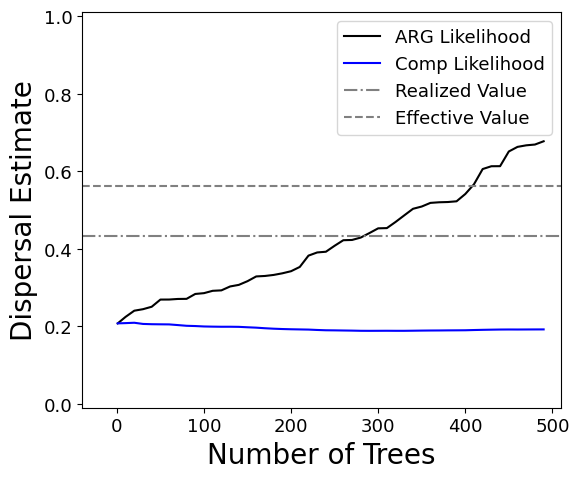

In [14]:
%matplotlib inline

dispersal_1 = np.loadtxt("slim_0.25rep1sigma_dispersalrateestimates_seqlen_100_chopped_10000_rep_0.txt")
plt.figure(figsize=(5.9,4.9))
plt.plot(dispersal_1[0:50,0], dispersal_1[0:50,2], color='black', label = "ARG Likelihood")
#plt.plot(dispersal_1[:,0], dispersal_1[:,9], color = 'red', linestyle = "dashdot", label = "Average w/ Full ARG")
plt.plot(dispersal_1[:50,0], dispersal_1[:50,5], color = 'blue', label = "Comp Likelihood")
#plt.plot(dispersal_1[:,0], dispersal_1[:,11], color = 'green', label = "Average (ARG)")
#plt.plot(dispersal_1[3:len(dispersal_1[:,0])-2,0], dispersal_1[3:len(dispersal_1[:,0])-2,13], color = 'red', label = "W 20")

plt.axhline(y=disp_x,label = "Realized Value", linestyle = '-.', color = 'grey')
plt.axhline(y=0.25**2+0.5,label = "Effective Value", linestyle = '--', color = 'grey')
plt.ylim((-0.01,1.01))

plt.legend(fontsize=13)
plt.xlabel("Number of Trees", fontsize = 20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Dispersal Estimate", fontsize = 20)
plt.xlim((-40,510))
plt.tight_layout()
plt.savefig('DispRateFinal.png', format='png')
plt.show()

### Code for Fig 3B and 3C

1 1.0 1
1 6.0 1
1 6.0 2
1 6.0 3
1 6.0 4
1 6.0 5
1 8.0 1
1 8.0 2
1 8.0 3
1 8.0 4
1 8.0 5


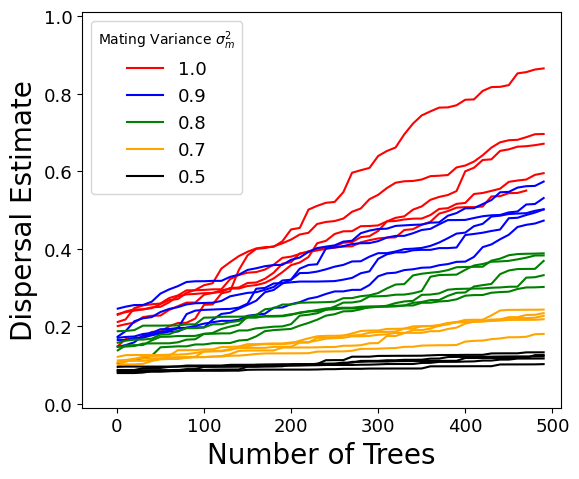

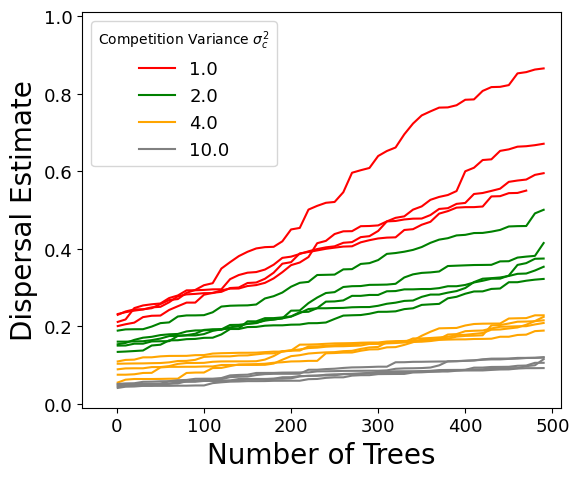

In [3]:
%matplotlib inline
#fig, ax = plt.subplots(2,1,figsize=(5.9,9.8))

plt.figure(figsize=(5.9,4.9))

colors = ["red","blue", "green", "orange","black","pink","purple"]
i = 0 

comp=1

for mating in reversed(np.arange(0.5,1.01,0.1)):
    mating = round(mating,2)
    if mating == 0.6:
        continue
    for rep in range(1,6):
        fname = "./SLiMSimulations/slim_disp0.25" +"_mating"+str(mating)+"_comp"+str(comp)+ "rep"+str(rep)+ "sigma.trees"
        dispersal_1 = np.loadtxt(fname+"_output.txt")
        if rep == 1 : 
            plt.plot(dispersal_1[:50,0], dispersal_1[:50,2], label = str(mating), color = colors[i])
        else: 
            plt.plot(dispersal_1[:50,0], dispersal_1[:50,2], color = colors[i])
        #plt.plot(dispersal_1[:,0], dispersal_1[:,9], color = 'red', linestyle = "dashdot", label = "Average w/ Full ARG")
        #plt.plot(dispersal_1[:,0], dispersal_1[:,5], color = 'blue', label = "Comp Likelihood")
        #plt.plot(dispersal_1[:,0], dispersal_1[:,11], color = 'green', label = "Average (ARG)")
        #plt.plot(dispersal_1[3:len(dispersal_1[:,0])-2,0], dispersal_1[3:len(dispersal_1[:,0])-2,13], color = 'red', label = "W 20")

        #plt.axhline(y=disp_x,label = "Realized Value", linestyle = '-.', color = 'grey')
        #plt.axhline(y=0.25**2+0.5,label = "Effective Value", linestyle = '--', color = 'grey')
    i += 1

plt.legend(fontsize=13, title = r"Mating Variance $\sigma^2_m$")
plt.ylim((-0.01,1.01))
plt.xlim((-40,510))
plt.xlabel("Number of Trees", fontsize = 20)
plt.ylabel("Dispersal Estimate", fontsize = 20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.savefig('DispRateMating.png', format='png')
plt.savefig('DispRateMating.svg', format='svg')

#plt.show()


plt.figure(figsize=(5.9,4.9))
colors = ["red", "green", "orange","black","pink","grey","purple","brown","silver"]
i = 0 

mating=1
for comp in [1.0, 2.0, 4.0, 6.0, 8.0, 10.0]:
    i += 1
    comp = round(comp,2)
    for rep in range(1,6):
        try:
            fname = "./SLiMSimulations/slim_disp0.25" +"_mating"+str(mating)+"_comp"+str(comp)+ "rep"+str(rep)+ "sigma.trees"
            dispersal_1 = np.loadtxt(fname+"_output.txt")
            if rep == 2: 
                plt.plot(dispersal_1[0:50,0], dispersal_1[0:50,2], label = str(comp), color = colors[i-1])
            else: 
                plt.plot(dispersal_1[0:50,0], dispersal_1[0:50,2], color = colors[i-1])
        except: 
            print(mating, comp, rep)
        #plt.plot(dispersal_1[:,0], dispersal_1[:,9], color = 'red', linestyle = "dashdot", label = "Average w/ Full ARG")
        #plt.plot(dispersal_1[:,0], dispersal_1[:,5], color = 'blue', label = "Comp Likelihood")
        #plt.plot(dispersal_1[:,0], dispersal_1[:,11], color = 'green', label = "Average (ARG)")
        #plt.plot(dispersal_1[3:len(dispersal_1[:,0])-2,0], dispersal_1[3:len(dispersal_1[:,0])-2,13], color = 'red', label = "W 20")

        #plt.axhline(y=disp_x,label = "Realized Value", linestyle = '-.', color = 'grey')
        #plt.axhline(y=0.25**2+0.5,label = "Effective Value", linestyle = '--', color = 'grey')


plt.legend(fontsize=13, title = r"Competition Variance $\sigma^2_c$")
plt.ylim((-0.01,1.01))
plt.xlim((-40,510))
plt.xlabel("Number of Trees", fontsize = 20)
plt.ylabel("Dispersal Estimate", fontsize = 20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.savefig('DispRateComp.png', format='png')
plt.savefig('DispRateComp.svg', format='svg')
plt.show()

## Code for Figure Fig 3D

In [10]:
ts = tskit.load("slim_0.25rep1sigma.trees")
nsamples = 100
keep_nodes = list(np.random.choice(ts.samples(),nsamples, replace=False))

#FULL ARG
ts_sim, sim_map = ts.simplify(samples=keep_nodes, keep_input_roots=False, keep_unary=True, map_nodes=True)
ts_filtered, filtered_maps = sparg.simplify_with_recombination(ts=ts_sim)
ts_chopped = sparg.chop_arg(ts_filtered,1000)
FullARG = sparg.SpatialARG(ts=ts_chopped, dimensions=2, verbose=False)
#print(ts_chopped.draw_text())
path_matrix = FullARG.paths_shared_time_matrix
P = np.zeros((len(path_matrix), nsamples))
for path_id, path in enumerate(FullARG.paths) : 
    P[path_id][path[0]] = 1 
inverted_paths_matrix = FullARG.inverted_paths_shared_time_matrix
inverse_sample_covariance_matrix = np.matmul(np.matmul(np.transpose(P),inverted_paths_matrix),P)

R = FullARG.roots_array
RP = np.matmul(np.matmul(np.transpose(P),inverted_paths_matrix),R)


sigma_squared = np.array([[0.5625,0.0],[0.0,0.5625]])
sample_covariance_matrix = np.kron(np.linalg.inv(inverse_sample_covariance_matrix),sigma_squared)

sample_locations = np.matmul(np.linalg.inv(inverse_sample_covariance_matrix), np.matmul(RP,np.array(list(FullARG.root_locations.values())))).reshape(1,200)[0]
simulated = np.random.multivariate_normal(mean = sample_locations, cov =sample_covariance_matrix )


#SINGLE TREE
breakpts = ts_chopped.breakpoints(as_array=True)
bp = breakpts[1]
ts_short = ts_chopped.keep_intervals(intervals=[(0,bp)], simplify=False).trim()
ts_short_sim, maps_short_sim = sparg.simplify_with_recombination(ts=ts_short)
ShortARG = sparg.SpatialARG(ts=ts_short_sim, dimensions=2, verbose=False)

path_matrix = ShortARG.paths_shared_time_matrix
P = np.zeros((len(path_matrix), nsamples))
for path_id, path in enumerate(ShortARG.paths) : 
    P[path_id][path[0]] = 1 
inverted_paths_matrix = ShortARG.inverted_paths_shared_time_matrix
inverse_sample_covariance_matrix = np.matmul(np.matmul(np.transpose(P),inverted_paths_matrix),P)

R = ShortARG.roots_array
RP = np.matmul(np.matmul(np.transpose(P),inverted_paths_matrix),R)

sigma_squared = np.array([[0.5625,0.0],[0.0,0.5625]])
sample_covariance_matrix = np.kron(np.linalg.inv(inverse_sample_covariance_matrix),sigma_squared)

sample_locations = np.matmul(np.linalg.inv(inverse_sample_covariance_matrix), np.matmul(RP,np.array(list(ShortARG.root_locations.values())))).reshape(1,200)[0]
short_simulated = np.random.multivariate_normal(mean = sample_locations, cov =sample_covariance_matrix )

#PARTIAL ARG
breakpts = ts_chopped.breakpoints(as_array=True)
bp = breakpts[ int(len(breakpts)/2) ]
bp = breakpts[200]
ts_med = ts_chopped.keep_intervals(intervals=[(0,bp)], simplify=False).trim()
ts_med_sim, maps_med_sim = sparg.simplify_with_recombination(ts=ts_med)
MedARG = sparg.SpatialARG(ts=ts_med_sim, dimensions=2, verbose=False)

path_matrix = MedARG.paths_shared_time_matrix
P = np.zeros((len(path_matrix), nsamples))
for path_id, path in enumerate(MedARG.paths) : 
    P[path_id][path[0]] = 1 
inverted_paths_matrix = MedARG.inverted_paths_shared_time_matrix
inverse_sample_covariance_matrix = np.matmul(np.matmul(np.transpose(P),inverted_paths_matrix),P)

R = MedARG.roots_array
RP = np.matmul(np.matmul(np.transpose(P),inverted_paths_matrix),R)

sigma_squared = np.array([[0.5625,0.0],[0.0,0.5625]])
sample_covariance_matrix = np.kron(np.linalg.inv(inverse_sample_covariance_matrix),sigma_squared)

sample_locations = np.matmul(np.linalg.inv(inverse_sample_covariance_matrix), np.matmul(RP,np.array(list(MedARG.root_locations.values())))).reshape(1,200)[0]
med_simulated = np.random.multivariate_normal(mean = sample_locations, cov =sample_covariance_matrix )

1918 has multiple children! Merge roots with caution.
1918 has multiple children! Merge roots with caution.


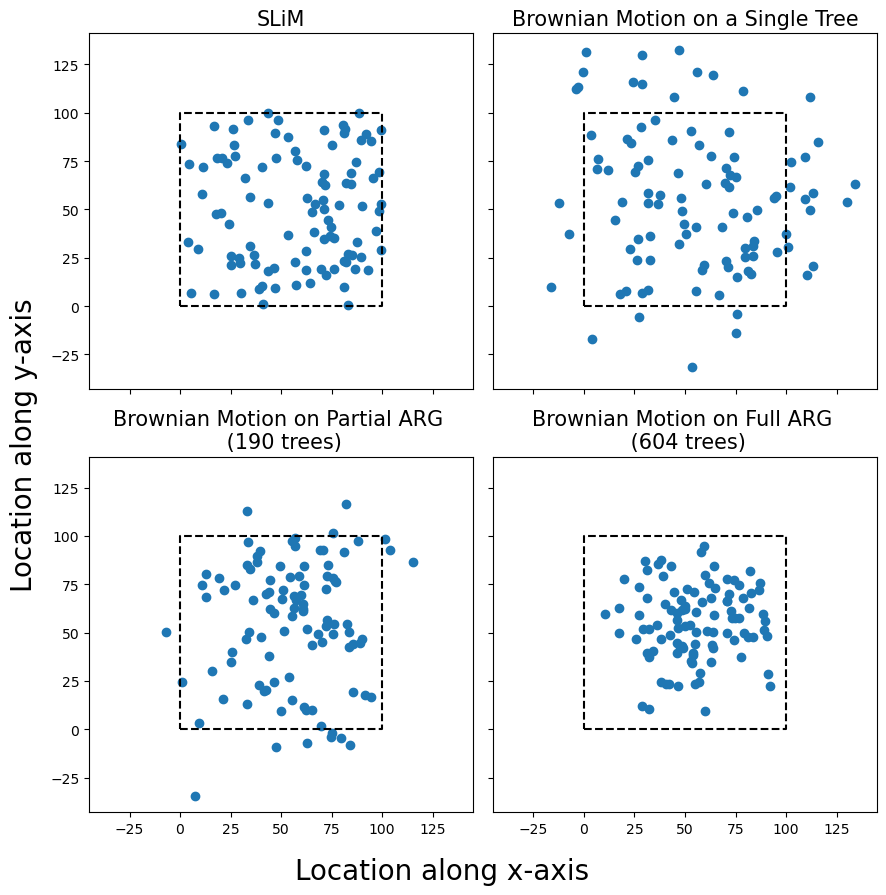

In [18]:
fig, ax = plt.subplots(2,2,sharex=True, sharey=True, figsize=(9,9))


ax[0][1].scatter(short_simulated[0:nsamples],short_simulated[nsamples:])
ax[0][1].plot([0,100,100,0,0],[0,0,100,100,0],linestyle = '--', color = 'black')

ax[0][1].set_title("Brownian Motion on a Single Tree", fontsize=15)
#ax[0][1].set_ylabel("Location along y-axis", fontsize = 20)

sim_locs = ts_chopped.tables.individuals[ts_chopped.tables.nodes.individual[np.where(ts_chopped.tables.nodes.flags == 1)[0]]].location
ax[0][0].scatter(sim_locs[::3],sim_locs[1::3])
ax[0][0].set_title("SLiM", fontsize=15)
ax[0][0].plot([0,100,100,0,0],[0,0,100,100,0],linestyle = '--', color = 'black')

ax[1][0].scatter(med_simulated[0:nsamples],med_simulated[nsamples:])
PartialARG_treecount = len(ts_med_sim.trees())
ax[1][0].set_title("Brownian Motion on Partial ARG \n ("+str(PartialARG_treecount)+" trees)", fontsize=15)
ax[1][0].plot([0,100,100,0,0],[0,0,100,100,0],linestyle = '--', color = 'black')
#ax[1][0].set_xlabel("Location along x-axis", fontsize = 20)

ax[1][1].scatter(simulated[0:nsamples],simulated[nsamples:])
FullARG_treecount = len(ts_chopped.trees())
ax[1][1].set_title("Brownian Motion on Full ARG \n ("+str(FullARG_treecount)+" trees)", fontsize=15)
ax[1][1].plot([0,100,100,0,0],[0,0,100,100,0],linestyle = '--', color = 'black')
#ax[1][1].set_xlabel("Location along x-axis", fontsize = 20)

fig.supxlabel("Location along x-axis", fontsize = 20)
fig.supylabel("Location along y-axis", fontsize = 20)
plt.xlim((-45,145))
plt.tight_layout()
plt.savefig("DispPattern.svg",format='svg')
plt.savefig("DispPattern.png",format='png')